In [45]:
# Add Libraries
using CSV
using DataFrames
using Dates
using GaussianMixtures
using StatsPlots

In [46]:
# Loading data and viewing its first 5 entries
data = CSV.read("OnlineRetail.csv",DataFrame)
first(data,5)

5×8 DataFrame
 Row │ InvoiceNo  StockCode  Description                        Quantity  Invo ⋯
     │ String     String     String?                            Int64     Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 536365     85123A     WHITE HANGING HEART T-LIGHT HOLD…         6  01-1 ⋯
   2 │ 536365     71053      WHITE METAL LANTERN                       6  01-1
   3 │ 536365     84406B     CREAM CUPID HEARTS COAT HANGER            8  01-1
   4 │ 536365     84029G     KNITTED UNION FLAG HOT WATER BOT…         6  01-1
   5 │ 536365     84029E     RED WOOLLY HOTTIE WHITE HEART.            6  01-1 ⋯
                                                               4 columns omitted

### Data Cleaning

In [47]:
# the size and the attribute names
size(data),names(data)

((541909, 8), ["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"])

In [48]:
# Brief description about the data
describe(data)

8×7 DataFrame
 Row │ variable     mean     min                             median   max      ⋯
     │ Symbol       Union…   Any                             Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ InvoiceNo             536365                                   C581569  ⋯
   2 │ StockCode             10002                                    m
   3 │ Description            4 PURPLE FLOCK DINNER CANDLES           wrongly
   4 │ Quantity     9.55225  -80995                          3.0      80995
   5 │ InvoiceDate           01-02-2011 08:23                         31-10-20 ⋯
   6 │ UnitPrice    4.61111  -11062.1                        2.08     38970.0
   7 │ CustomerID   15287.7  12346                           15152.0  18287
   8 │ Country               Australia                                Unspecif
                                                               3 columns omitted

* The data has 8 attributes.InvoiceNo, Description, StockCode, InvoiceDate, Country are of String type. Quantity and UnitPrice are Integer type values. 
* A peculiar thing to note is that Quantity has negative values. These -ve values corresponds to the Canceled order which are uniquely Identified by their InvoiceNo begining with C as shown below.

In [49]:
# Cancelled Orders
first(filter(row -> row[:Quantity] < 0, data),5)

5×8 DataFrame
 Row │ InvoiceNo  StockCode  Description                       Quantity  Invoi ⋯
     │ String     String     String?                           Int64     Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ C536379    D          Discount                                -1  01-12 ⋯
   2 │ C536383    35004C     SET OF 3 COLOURED  FLYING DUCKS         -1  01-12
   3 │ C536391    22556      PLASTERS IN TIN CIRCUS PARADE          -12  01-12
   4 │ C536391    21984      PACK OF 12 PINK PAISLEY TISSUES        -24  01-12
   5 │ C536391    21983      PACK OF 12 BLUE PAISLEY TISSUES        -24  01-12 ⋯
                                                               4 columns omitted

#### Identify null values

In [50]:
show(mapcols(x -> count(ismissing, x), data),allcols = true)

1×8 DataFrame
 Row │ InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  CustomerID  Country 
     │ Int64      Int64      Int64        Int64     Int64        Int64      Int64       Int64   
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │         0          0         1454         0            0          0      135080        0

##### Remove data entries 

* From the CustomerID column, nearly 25% data entries are missing. Therefore, almost 25% of invoices are not assigned to any customer. 
* These invoices cannot be mapped to any random customers without of lack of knowledge. Therefore, these entries needs to be removed from the dataset.

In [51]:
data = dropmissing(data, :CustomerID)
show(mapcols(x -> count(ismissing, x), data),allcols = true)

1×8 DataFrame
 Row │ InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  CustomerID  Country 
     │ Int64      Int64      Int64        Int64     Int64        Int64      Int64       Int64   
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │         0          0            0         0            0          0           0        0

#### Identify duplicate entries


In [52]:
println("Duplicate values in the data: ",count(nonunique(data)))
# Remove duplicate values from data
unique!(data) 
print("Duplicate values in the data: ",count(nonunique(data)))

Duplicate values in the data: 5225
Duplicate values in the data: 0

####  Removing entries with -ve Quantity values

In [53]:
data=filter(row -> row[:Quantity] > 1, data)
describe(data)

8×7 DataFrame
 Row │ variable     mean     min                             median   max      ⋯
     │ Symbol       Union…   Any                             Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ InvoiceNo             536365                                   581587   ⋯
   2 │ StockCode             10002                                    POST
   3 │ Description            4 PURPLE FLOCK DINNER CANDLES           ZINC WIR
   4 │ Quantity     15.7718  2                               6.0      80995
   5 │ InvoiceDate           01-02-2011 08:23                         31-10-20 ⋯
   6 │ UnitPrice    2.64381  0.0                             1.65     649.5
   7 │ CustomerID   15196.9  12346                           15046.0  18287
   8 │ Country               Australia                                Unspecif
                                                               3 columns omitted

#### Changing date from string to dateTime in Julia

In [54]:
DATEFORMAT = DateFormat("dd-mm-yyyy HH:MM")
data.InvoiceDate = Date.(data.InvoiceDate,  DATEFORMAT)
describe(data)

8×7 DataFrame
 Row │ variable     mean     min                             median   max      ⋯
     │ Symbol       Union…   Any                             Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ InvoiceNo             536365                                   581587   ⋯
   2 │ StockCode             10002                                    POST
   3 │ Description            4 PURPLE FLOCK DINNER CANDLES           ZINC WIR
   4 │ Quantity     15.7718  2                               6.0      80995
   5 │ InvoiceDate           2010-12-01                               2011-12- ⋯
   6 │ UnitPrice    2.64381  0.0                             1.65     649.5
   7 │ CustomerID   15196.9  12346                           15046.0  18287
   8 │ Country               Australia                                Unspecif
                                                               3 columns omitted

#### Adding a column "TotalAmount" to store the total money spent by each transaction

In [55]:
data.TotalAmount = data.Quantity .* data.UnitPrice
data.TotalAmount

323127-element Array{Float64,1}:
 15.299999999999999
 20.34
 22.0
 20.34
 20.34
 15.3
 25.5
 11.100000000000001
 11.100000000000001
 54.08
 12.600000000000001
 12.600000000000001
 30.0
  ⋮
 15.0
 15.0
 15.0
 15.0
 15.6
 23.4
 16.6
 10.2
 12.600000000000001
 16.6
 16.6
 14.850000000000001

### Exploratory Data Analysis

##### Total number of customers, products and transactions in the dataset ?


In [56]:
DataFrame(Customers = length(unique(data[!,"CustomerID"])) , Products = length(unique(data[!,"StockCode"])),Transactions= length(unique(data[!,"InvoiceNo"])))  

1×3 DataFrame
 Row │ Customers  Products  Transactions 
     │ Int64      Int64     Int64        
─────┼───────────────────────────────────
   1 │      4328      3572         18257

* The dataset contain the recods of 4328 customers who bought 3572 different items.
* There are $\sim$18,000 transactions which are carried out.

##### Number of products purchased in every transaction

In [57]:
first(sort(combine(groupby(data, [:CustomerID, :InvoiceNo]), nrow => :ProductsPerTransaction),(:CustomerID)),10)

10×3 DataFrame
 Row │ CustomerID  InvoiceNo  ProductsPerTransaction 
     │ Int64       String     Int64                  
─────┼───────────────────────────────────────────────
   1 │      12346  541431                          1
   2 │      12347  537626                         31
   3 │      12347  542237                         29
   4 │      12347  549222                         24
   5 │      12347  556201                         18
   6 │      12347  562032                         22
   7 │      12347  573511                         47
   8 │      12347  581180                         11
   9 │      12348  539318                         17
  10 │      12348  541998                          5

* There are some users who bought only comes one time on the E-commerce platform and purchased one   
  item. The example of this kind of user is customerID 12346.  

* There are some users who frequently buy large number of items per order. The example of this kind of 
  user is customerID 12347.  

##### Number of transactions made by each customer

In [58]:
# transactionsPerCustomer=groupby(data,[:CustomerID,:Country])
# # groupby(data,[:CustomerID,:Country,:InvoiceNo])
transactionsPerCustomer = combine(groupby(data, [:CustomerID,:Country]), :InvoiceNo=>length∘unique)
first(rename!(transactionsPerCustomer, :InvoiceNo_length_unique => :Transactions),10)

10×3 DataFrame
 Row │ CustomerID  Country         Transactions 
     │ Int64       String          Int64        
─────┼──────────────────────────────────────────
   1 │      17850  United Kingdom            34
   2 │      13047  United Kingdom             9
   3 │      12583  France                    15
   4 │      13748  United Kingdom             5
   5 │      15100  United Kingdom             3
   6 │      15291  United Kingdom            14
   7 │      14688  United Kingdom            21
   8 │      17809  United Kingdom            12
   9 │      15311  United Kingdom            91
  10 │      16098  United Kingdom             7

In [59]:
# Top 5 customers
first(sort(transactionsPerCustomer,(:Transactions),rev=true),5)

5×3 DataFrame
 Row │ CustomerID  Country         Transactions 
     │ Int64       String          Int64        
─────┼──────────────────────────────────────────
   1 │      14911  EIRE                     197
   2 │      12748  United Kingdom           177
   3 │      17841  United Kingdom           120
   4 │      13089  United Kingdom            97
   5 │      15311  United Kingdom            91

* The table above hows that the maximum number of transactions(invoices),197, were placed by the customer 14911 in EIRE. 
* Among our top 5 customers, United Kingdom customers secured the last 4 positions indicating that, it can be a potential market for high growth and profit. Therefore, investing more in UK would be beneficial.

##### Money spent by each customers

In [60]:
moneySpent = combine(groupby(data,[:CustomerID,:Country]),:TotalAmount)
#Top 5
first(sort(moneySpent,(:TotalAmount),rev=true),5)

5×3 DataFrame
 Row │ CustomerID  Country         TotalAmount  
     │ Int64       String          Float64      
─────┼──────────────────────────────────────────
   1 │      16446  United Kingdom      1.6847e5
   2 │      12346  United Kingdom  77183.6
   3 │      15098  United Kingdom  38970.0
   4 │      17450  United Kingdom   7144.72
   5 │      15749  United Kingdom   6539.4

* The table depicts the total amount invested by each customer along with its country. For instance, CustomerID 16446 spent the most amount among the rest.
* Moreover, UK customers were among the top 5 who spent the most amount. 

##### Number of transactions per Month

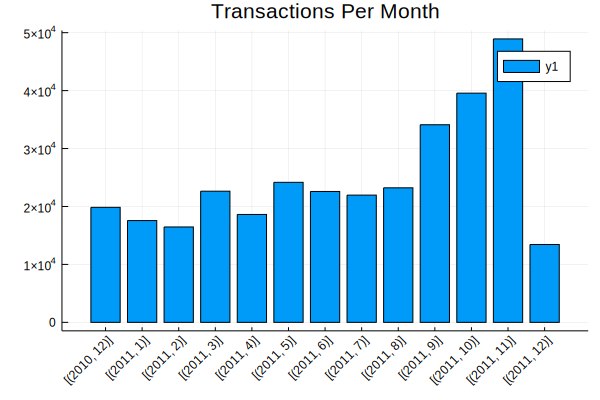

In [61]:
data[!, :month] = yearmonth.(data[!, :InvoiceDate])
transactionsPerMonth = combine(groupby(data, :month),nrow)
transactionsPerMonth[!, :month]=map(x->string(x), eachrow(transactionsPerMonth.month))
bar(transactionsPerMonth.month,
    transactionsPerMonth.nrow,
    title = "Transactions Per Month",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

* According to the graph above, most transactions were in November,2011 in a time frame of 11 months.
* Unfortunately we only have 9 days of data for December, 2011. But we hope for a monotonic increase.
* The boom in sales from September, 2011 to November 2011 can be owed to the Holiday season.

##### Number of transactions per Day

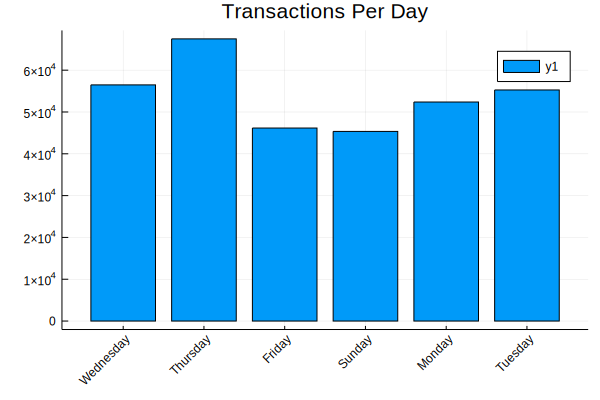

In [62]:
data[!, :day] = dayname.(data[!, :InvoiceDate])
transactionsPerDay = combine(groupby(data, :day),nrow)
bar(transactionsPerDay.day,
    transactionsPerDay.nrow,
    title = "Transactions Per Day",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])


* The above bar graph depits the cummulative transcations per week throughout the time frame(Dec,2010 to Dec, 2011).
* According to the bar graph above, the most and the least transcations made was on Thursdays and Sundays respectively.

##### Unit Price Description

In [63]:
# Unit Price
describe(data.UnitPrice)

Summary Stats:
Length:         323127
Missing Count:  0
Mean:           2.643813
Minimum:        0.000000
1st Quartile:   0.850000
Median:         1.650000
3rd Quartile:   2.950000
Maximum:        649.500000
Type:           Float64


We see that there are unit price = 0 (FREE items)

There are some free items given to customers from time to time.

In [64]:
# Distribution of Unit Price
bp1 = boxplot(data.UnitPrice)
StatsPlots.plot(bp1)

In [65]:
data_free = filter(row -> row[:UnitPrice]==0 , data)

27×11 DataFrame
 Row │ InvoiceNo  StockCode  Description                        Quantity  Invo ⋯
     │ String     String     String?                            Int64     Date ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 539263     22580      ADVENT CALENDAR GINGHAM SACK              4  2010 ⋯
   2 │ 539722     22423      REGENCY CAKESTAND 3 TIER                 10  2010
   3 │ 540372     22090      PAPER BUNTING RETROSPOT                  24  2011
   4 │ 540372     22553      PLASTERS IN TIN SKULLS                   24  2011
   5 │ 543599     84535B     FAIRY CAKES NOTEBOOK A6 SIZE             16  2011 ⋯
   6 │ 547417     22062      CERAMIC BOWL WITH LOVE HEART DES…        36  2011
   7 │ 548318     22055      MINI CAKE STAND  HANGING STRAWBE…         5  2011
   8 │ 548871     22162      HEART GARLAND RUSTIC PADDED               2  2011
   9 │ 553000     47566      PARTY BUNTING                             4  2011 ⋯
  10 │ 554037     22619      SET OF 6 SOLDIER SKITTLES                80  2011
  11 │ 561669     22960      JAM MAKING SET WITH JARS                 11  2011
  ⋮  │     ⋮          ⋮                      ⋮                     ⋮           ⋱
  18 │ 572893     21208      PASTEL COLOUR HONEYCOMB FAN               5  2011
  19 │ 574138     23234      BISCUIT TIN VINTAGE CHRISTMAS           216  2011 ⋯
  20 │ 574175     22065      CHRISTMAS PUDDING TRINKET POT            12  2011
  21 │ 574469     22385      JUMBO BAG SPACEBOY DESIGN                12  2011
  22 │ 574879     22625      RED KITCHEN SCALES                        2  2011
  23 │ 575579     22437      SET OF 9 BLACK SKULL BALLOONS            20  2011 ⋯
  24 │ 575579     22089      PAPER BUNTING VINTAGE PAISLEY            24  2011
  25 │ 577129     22464      HANGING METAL HEART LANTERN               4  2011
  26 │ 577314     23407      SET OF 2 TRAYS HOME SWEET HOME            2  2011
  27 │ 578841     84826      ASSTD DESIGN 3D PAPER STICKERS        12540  2011 ⋯
                                                    7 columns and 6 rows omitted

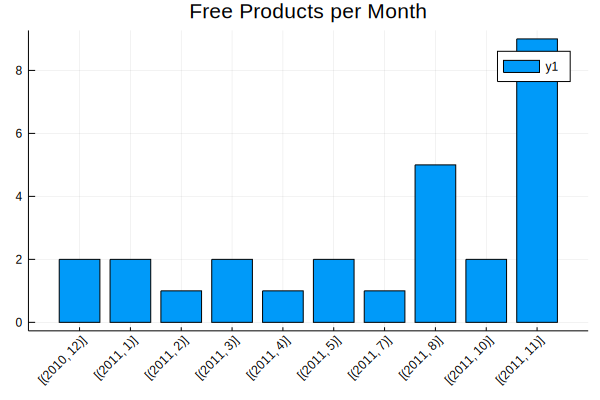

In [66]:
data_free[!, :month] = yearmonth.(data_free[!, :InvoiceDate])
freeOrder = combine(groupby(data_free, :month),nrow)
freeOrder[!, :month]=map(x->string(x), eachrow(freeOrder.month))
bar(freeOrder.month,
    freeOrder.nrow,
    title = "Free Products per Month",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

* On average, the company gave out 2 FREE products to customers each month except in June and September in 2011
* Because of the Thanksgiving in August and, the holiday season in November, more and more products were given free
* Free products given to customers in November were almost 3 folds to the average free products given during the rest of the time frame

##### Products Sold per Country

Unique countries in the dataset: 37

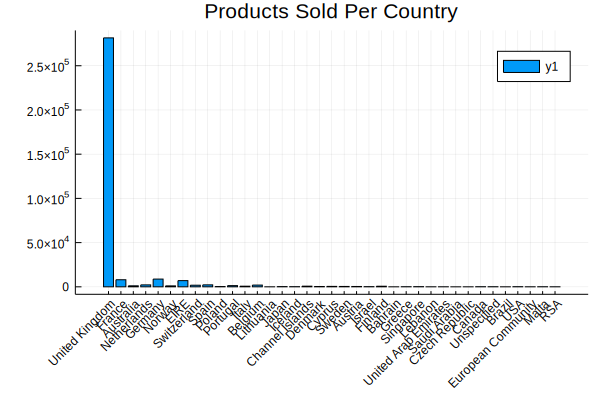

In [67]:
print("Unique countries in the dataset: ",length(unique(data[!,"Country"])))
orderPerCountry =   combine(groupby(data, :Country), nrow)
bar(orderPerCountry.Country,
    orderPerCountry.nrow,
    title = "Products Sold Per Country",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

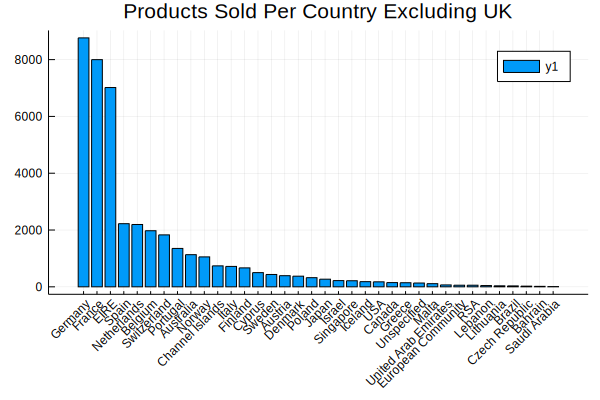

In [68]:
delete!(orderPerCountry, 1)
orderPerCountry= sort(orderPerCountry,:nrow,rev=true)
bar(orderPerCountry.Country,
    orderPerCountry.nrow,
    title = "Products Sold Per Country Excluding UK",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])


* Maximum sales occured in UK followed by France , EIRE and Spain. 
* Therefore, investing the UK will surely lead to higher profits.

##### Money Spent by Each Country

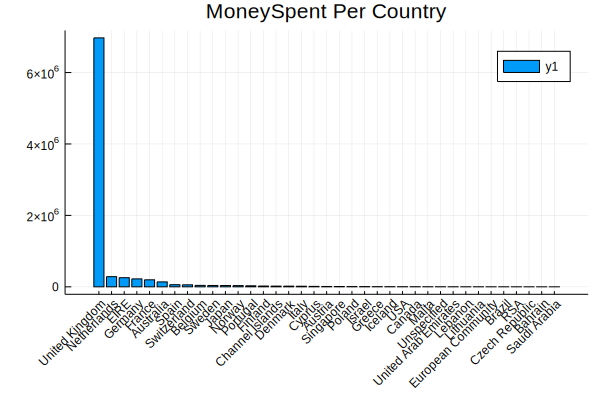

In [69]:
moneyPerCount = sort(combine(groupby(data, [:Country]), :TotalAmount => sum),:TotalAmount_sum,rev=true)
bar(moneyPerCount.Country,
    moneyPerCount.TotalAmount_sum,
    title = "MoneySpent Per Country",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])


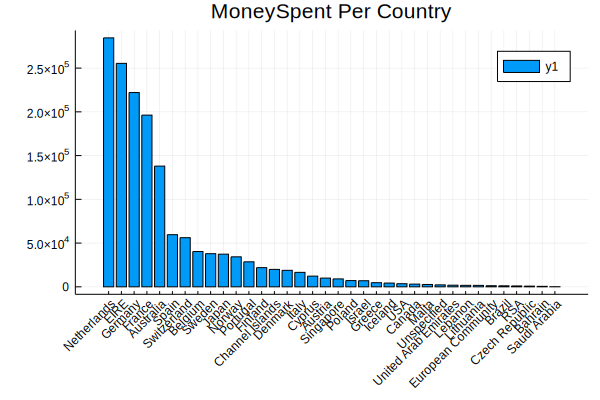

In [70]:
delete!(moneyPerCount, 1)
bar(moneyPerCount.Country,
    moneyPerCount.TotalAmount_sum,
    title = "MoneySpent Per Country",
    xticks = :all,
    xrotation = 45,
    size = [600, 400])

* Uk ranked top among the other countries in terms of money spent.
* This trend seems to continue in all European countries as depicted by the second graph. 
* Saudi Arabia spent the least money and therefore, we should re-consider the idea of investing there.